<a href="https://colab.research.google.com/github/puneetsingla17/Reinforcement-Learning-Pytorch/blob/master/PACMAN_env_dqn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install pybullet --upgrade
!pip install ptan
import pybullet_envs
import ptan
import math
import gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as op

     |████████████████████████████████| 100.7MB 108kB/s 
     |████████████████████████████████| 773.1MB 24kB/s 
  Created wheel for ptan: filename=ptan-0.6-cp36-none-any.whl size=23502 sha256=5d7ac66fb2a017979e34b0c05c5754355dd4000a54772d03da6c30b119173d3a
  Stored in directory: /root/.cache/pip/wheels/f0/4b/2f/9a45fd39b0a614a2716bc6128a7f1adb4647f323a2d90783f2
Successfully built ptan
ERROR: torchvision 0.6.1+cu101 has requirement torch==1.5.1, but you'll have torch 1.3.0 which is incompatible.
  Found existing installation: torch 1.5.1+cu101
    Uninstalling torch-1.5.1+cu101:
      Successfully uninstalled torch-1.5.1+cu101


In [2]:
import cv2
from collections import deque,namedtuple
import random
from ptan.common.wrappers import ImageToPyTorch,ScaledFloatFrame,MaxAndSkipEnv,FrameStack,LazyFrames
from gym import spaces
import numpy as np

In [3]:
env=gym.make("MsPacmanNoFrameskip-v0")

In [4]:
#Description regarding environment space and action space
print(env.action_space)
print(env.observation_space)

Discrete(9)
Box(210, 160, 3)


In [5]:
#action means
env.unwrapped.get_action_meanings()

['NOOP',
 'UP',
 'RIGHT',
 'LEFT',
 'DOWN',
 'UPRIGHT',
 'UPLEFT',
 'DOWNRIGHT',
 'DOWNLEFT']

In [6]:
#Hyperparameters Dictionary
hyper={"maxskip":3,
       "nstack":4,
       "imgshape":(4,84,84),
       "outchannels":[32,64,64,128],
       "buffersize":50000,
       "eps":0.05,
       "gamma":0.99,
       "softstep":6,
       "tau":0.99,
       "batchsize":64,
       "epochs":15,
       "lr":0.0001,
       "initialsteps":2000
       }

In [7]:
class scaleframe(gym.ObservationWrapper):
  def __init__(self,env):
    super().__init__(env)
    self.env=env
    
  def observation(self,obs):
    return np.array(obs).astype(np.float32)/255.0

In [8]:
class ProcessFrame84(gym.ObservationWrapper):
  def __init__(self,env):
    super().__init__(env)
    self.env=env
    
  def observation(self,x):
    return ProcessFrame84.process(x)

  @staticmethod
  def process(ob):
    img=np.reshape(ob,[210,160,3]).astype(np.float32)
    img=img[:,:,0]*0.299+img[:,:,1]*0.587+img[:,:,2]*0.114
    resizedimg=cv2.resize(img,(84,110),interpolation=cv2.INTER_AREA)
    xt=resizedimg[18:102,:]
    xt=np.reshape(xt,(84,84,1))
    return xt.astype(np.uint8)

In [9]:
class FrameStack(gym.Wrapper):
    def __init__(self, env, k):
        """Stack k last frames.
        Returns lazy array, which is much more memory efficient.
        See Also
        --------
        baselines.common.atari_wrappers.LazyFrames
        """
        gym.Wrapper.__init__(self, env)
        self.k = k
        self.frames = deque([], maxlen=k)
        shp = (1,84,84)
        self.observation_space = spaces.Box(low=0, high=255, shape=(shp[0]*k, shp[1], shp[2]), dtype=np.float32)

    def reset(self):
        ob = self.env.reset()
        for _ in range(self.k):
            self.frames.append(ob.reshape(1,84,84))
        return np.concatenate(self.frames,axis=0)

    def step(self, action):
        ob, reward, done, info = self.env.step(action)
        self.frames.append(ob.reshape(1,84,84))
        return np.concatenate(self.frames,axis=0), reward, done, info


In [10]:
# Preprocessing the environment 
# Normalizing scale of env values
# Concatenate multiple frames together to get environment dynamics
# Applying action for k consecutive frames and getting total reward out with obs as max of last two frames > maxandskipenv
# resizing to 84 84 1
env=gym.make("MsPacmanNoFrameskip-v0")
env=MaxAndSkipEnv(env,skip=hyper['maxskip'])
env=ProcessFrame84(env)
env=FrameStack(env,hyper['nstack'])
env=scaleframe(env)

In [11]:
# Agent 
class agent(nn.Module):
  def __init__(self,imgshape,nactions,outchannel):
    super().__init__()
    self.cnn1=nn.Conv2d(4,outchannel[0],kernel_size=4,stride=2)   # 41
    self.bn1=nn.BatchNorm2d(outchannel[0])
    self.cnn2=nn.Conv2d(outchannel[0],outchannel[1],kernel_size=8) # 34
    self.bn2=nn.BatchNorm2d(outchannel[1])
    self.cnn3=nn.Conv2d(outchannel[1],outchannel[2],kernel_size=8,stride=2) 
    self.bn3=nn.BatchNorm2d(outchannel[2])
    self.cnn4=nn.Conv2d(outchannel[2],outchannel[3],kernel_size=4,stride=2)
    self.bn4=nn.BatchNorm2d(outchannel[3])
    self.shape=imgshape
    num=self.calculateddim()
    self.fc1=nn.Linear(num,64)
    self.fc2=nn.Linear(64,nactions)
    
  def forward(self,x):
    # print(x.shape)
    # x=x.permute(0,3,1,2)
    # print(x.shape)
    out=f.relu(self.cnn1(x))
    out=self.bn1(out)
    out=f.relu(self.cnn2(out))
    out=self.bn2(out)
    out=f.relu(self.cnn3(out))
    out=self.bn3(out)
    out=f.relu(self.cnn4(out))
    out=self.bn4(out)
    out=nn.Flatten()(out)
    out=f.relu(self.fc1(out))
    return self.fc2(out)

  def calculateddim(self):
    out=self.cnn4(self.cnn3(self.cnn2(self.cnn1(torch.zeros(1,*self.shape)))))
    return out.shape[1]*out.shape[2]*out.shape[3]

In [12]:
class experiencebuffer:
  def __init__(self,length):
    self.buffer=deque(maxlen=length)
    self.datapoint=namedtuple("data",['state','action','reward',"done",'nextstate'])
  
  def add(self,state,action,reward,done,nextstate):
    self.buffer.append(self.datapoint(state,action,reward,done,nextstate))
  
  def sample(self,batchsize):
    batch=random.sample(self.buffer,hyper['batchsize'])
    state=torch.FloatTensor([e.state for e in batch if e.nextstate is not None])
    action=torch.FloatTensor([e.action for e in batch if e.nextstate is not None])
    nextstate=torch.FloatTensor([e.nextstate for e in batch if e.nextstate is not None])
    reward=torch.FloatTensor([e.reward for e in batch if e.nextstate is not None])
    done=torch.LongTensor([e.done for e in batch if e.nextstate is not None])
    return state,action,reward,done,nextstate

In [13]:
class agentclass:
  # soft update after some k steps
  # hard update in initial
  def __init__(self,device):
    self.device=device
    self.dqnagent=agent(hyper['imgshape'],9,hyper['outchannels']).to(device)
    self.tgtdqnagent=agent(hyper['imgshape'],9,hyper['outchannels']).to(device)
    self.optimizer=op.Adam(self.dqnagent.parameters(),lr=hyper['lr'])
    self.memory=experiencebuffer(hyper['buffersize'])
  
  def softupdate(self,tau):
    for i,j in zip(self.dqnagent.parameters(),self.tgtdqnagent.parameters()):
      j.data.copy_(tau*(j.data)+(1-tau)*(i.data))
  
  def hardupdate(self):
      for i,j in zip(self.dqnagent.parameters(),self.tgtdqnagent.parameters()):
        j.data.copy_(i.data)
        
  def step(self,state,eps):
    st=torch.FloatTensor(state).unsqueeze(0).to(self.device)
    action=self.dqnagent(st).squeeze(0).cpu().data.numpy()
    if random.random()>eps:
      actionval=np.argmax(action)
    else:
      actionval=random.choice(range(9))
    nextstate,reward,done ,_=env.step(actionval)
    self.memory.add(state,actionval,reward,done,nextstate)
    return nextstate,reward,done

  def train(self):
    state,action,reward,done,nextstate=self.memory.sample(hyper['batchsize'])
    state_qval=self.dqnagent(state.to(self.device)).gather(1,action.unsqueeze(1).long().to(self.device)).squeeze(1) # current state vals
    nextstate_qval=self.tgtdqnagent(nextstate.to(self.device)).max(1)[0].data
    actual_qval=reward.to(self.device)+hyper['gamma']*nextstate_qval
    loss=f.mse_loss(state_qval,actual_qval)
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()
    return loss.item()

In [14]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
device

device(type='cuda')

In [16]:
agent1=agentclass(device)
agent1.hardupdate()

In [37]:
score2=[]
score2.extend(score)

In [38]:
score2

[460.0, 320.0, 390.0, 350.0, 370.0, 750.0, 790.0, 430.0, 440.0, 830.0]

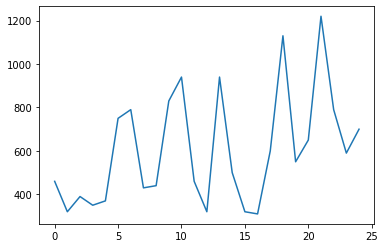

In [72]:
plt.plot(score2)

In [ ]:
count=0
losses=[]
for i in range(hyper['epochs']):
  state=env.reset()
  sc=0
  while True:
    nextstate,reward,done=agent1.step(state,hyper['eps'])

    if done:
      print(count)
      break
    state=nextstate
    count+=1
    sc+=reward
    
    if (count%800)==0:
      print(count)
      print(len(agent1.memory.buffer))

    if count<hyper['initialsteps']:
      continue
    
    if (count%hyper['softstep'])==0:
      agent1.softupdate(hyper['tau'])

    l=agent1.train()
    losses.append(l)
  print(sc)
  score2.append(sc)

682
360.0
800
24510
1551
540.0
1600
25311
2055
320.0
2400
26112
2700
420.0
3200
26913
3382
560.0
4000
27714
4144
330.0
4800
28515
5008
860.0
5600
29316
6085
600.0
6400
30117
7119
590.0
7200
30918
7847
1040.0
8000
31719
8713
720.0
8800
32520
9358
400.0


In [1]:
score2

NameError: ignored

In [40]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [41]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) # error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay

In [42]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

In [64]:
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

In [65]:
def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [66]:
env1 = wrap_env(gym.make("MsPacmanNoFrameskip-v0"))

In [67]:
env2=MaxAndSkipEnv(env1,skip=hyper['maxskip'])
env2=ProcessFrame84(env2)
env2=FrameStack(env2,hyper['nstack'])
env2=scaleframe(env2)

In [68]:
state=env2.reset()

In [69]:
  def tgtstep(agent,state):
    st=torch.FloatTensor(state).unsqueeze(0).to(device)
    action=agent(st).squeeze(0).cpu().data.numpy()
    # if random.random()>eps:
    actionval=np.argmax(action)
    # else:
    #   actionval=random.choice(range(9))
    # nextstate,reward,done ,_=env.step(actionval)
    # self.memory.add(state,actionval,reward,done,nextstate)
    return actionval

In [70]:
count=0
while count<1000:
  env1.render()
  # obs=ptan.agent.float32_preprocessor(obs)
  # action=model.forward(obs)[0].data.cpu().numpy()
  action=tgtstep(agent1.tgtdqnagent,state)
  obs,rew,done,_=env2.step(action)
  state=obs
  count+=1
  if done:
    break

env2.close()
env1.close()

In [71]:
show_video()